In [24]:
from IPython.core.display import HTML, display
import pickle
import pandas as pd
import numpy as np

import pymc3 as pm

import matplotlib.pyplot as pl
import matplotlib.cm as cm

In [2]:
%matplotlib inline
display(HTML("<style>.container{width: 90%}</style>"))

In [5]:
with open('./pklJar/dict_df_phytoC.pkl', 'rb') as f:
    datadict = pickle.load(f)
    df_aqua = datadict['aqua']
    df_swf = datadict['swf']
    df_swf_aqua = datadict['swf_aqua']
    df_mean = datadict['mean']

In [7]:
df_aqua.head().T

datetime,2002-07-16 22:10:00,2002-08-19 09:03:30,2002-09-16 01:52:30,2002-10-16 13:17:30,2002-11-16 01:15:00
bbp_443_giop_mean,0.001823,0.001815,0.001882,0.001882,0.001899
phyto_C_2.5%,20.197499,20.084285,20.848132,20.842028,21.004253
phyto_C_25%,21.343615,21.245797,21.968674,21.966110,22.146285
phyto_C_mean,21.901264,21.801759,22.597096,22.594274,22.792814
phyto_C_75%,22.538910,22.434313,23.204997,23.202138,23.393081
phyto_C_97.5%,23.794579,23.661935,24.574319,24.567595,24.764797
phyto_C_anomaly,0.985239,0.658900,0.943811,0.085470,-0.186034
bbp_443_swf_adjusted,0.001770,0.001761,0.001829,0.001829,0.001845


In [14]:
df_aqua_r = df_aqua[['phyto_C_mean']].resample('MS', loffset=pd.Timedelta(14, 'd')).first()

In [15]:
df_aqua_r.head()

,phyto_C_mean
datetime,
2002-07-15,21.901264
2002-08-15,21.801759
2002-09-15,22.597096
2002-10-15,22.594274
2002-11-15,22.792814


In [16]:
idx = df_aqua_r.index.searchsorted(pd.to_datetime('2017-12-15'))

In [38]:
def dates_to_idx(timelist):
    reference_time = pd.to_datetime('1958-03-15')
    t = (timelist - reference_time) / pd.Timedelta(1, "Y")
    return np.asarray(t)

t = dates_to_idx(df_aqua_r.index)

# normalize CO2 levels
y = df_aqua_r.phyto_C_mean.values
first_co2 = y[0]
std_co2 = np.std(y)
y_n = (y - first_co2) / std_co2

df_aqua_r = df_aqua_r.assign(t = t)
df_aqua_r = df_aqua_r.assign(y_n = y_n)

In [39]:
train_set = df_aqua_r.loc[:'2017-12-15']
test_set = df_aqua_r.loc['2018-01-15':]

In [40]:
test_set.head()

,phyto_C_mean,t,y_n
datetime,,,
2018-01-15,21.513005,59.839696,-0.544847
2018-02-15,20.960197,59.924571,-1.320607
2018-03-15,21.110279,60.001232,-1.109997
2018-04-15,21.622626,60.086107,-0.391016
2018-05-15,21.784587,60.168244,-0.163735


$$f(t)\sim GP_{slow}(0, k_1(t, t')) + GP_{med}(0, k_2(t, t')) + GP_{per}(0, k_3(t,t')) + GP_{noise}(0, k_n(t, t'))%$$

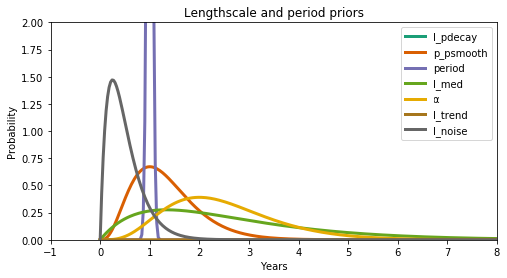

In [37]:

x = np.linspace(0, 150, 5000)
priors = [
    ("l_pdecay",  pm.Gamma.dist(alpha=10, beta=0.075)),
    ("p_psmooth", pm.Gamma.dist(alpha=4,  beta=3)),
    ("period",    pm.Normal.dist(mu=1.0,  sd=0.05)),
    ("l_med",     pm.Gamma.dist(alpha=2,  beta=0.75)),
    ("α",         pm.Gamma.dist(alpha=5,  beta=2)),
    ("l_trend",   pm.Gamma.dist(alpha=4,  beta=0.1)),
    ("l_noise",   pm.Gamma.dist(alpha=2,  beta=4))]
colorlist = cm.Dark2(np.linspace(0, 1, len(priors)))
f, ax = pl.subplots(figsize=(8, 4))
ax.set_title('Lengthscale and period priors')
ax.set_xlim((-1, 8))
ax.set_ylim((0, 2))
ax.set_ylabel('Probability')
ax.set_xlabel('Years')
for color, prior in zip(colorlist, priors):
    pl.plot(x, np.exp(prior[1].logp(x).eval()), label=prior[0],
           lw=3, color=color)
ax.legend();

* l_pdecay: The periodic decay. The smaller this parameter is, the faster the periodicity goes away. I doubt that the seasonality of the CO2 will be going away any time soon (hopefully), and there’s no evidence for that in the data. Most of the prior mass is from 60 to >140 years.
* l_psmooth: The smoothness of the periodic component. It controls how “sinusoidal” the periodicity is. The plot of the data shows that seasonality is not an exact sine wave, but its not terribly different from one. We use a Gamma whose mode is at one, and doesn’t have too large of a variance, with most of the prior mass from around 0.5 and 2.
period: The period. We put a very strong prior on p, the period that is centered at one. R+W fix p=1, since the period is annual.
* l_med: This is the lengthscale for the short to medium long variations. This prior has most of its mass below 6 years.
* α: This is the shape parameter. This prior is centered at 3, since we’re expecting there to be some more variation than could be explained by an exponentiated quadratic.
* l_trend: The lengthscale of the long term trend. It has a wide prior with mass on a decade scale. Most of the mass is between 10 to 60 years.
* l_noise: The lengthscale of the noise covariance. This noise should be very rapid, in the scale of several months to at most a year or two.

We know beforehand which GP components should have a larger magnitude, so we include this information in the scale parameters.



In [ ]:
x = np.linspace(0, 4, 5000)
priors = [
    ("n_per", pm.HalfCauchy.dist(beta=2)),
    ("n_med", pm.HalfCauchy.dist(beta=1.0)),
    ("n_trend", pm.HalfCauchy.dist(beta=3)),
    ("sig", pm.HalfNormal.dist(sd=0.25)),
    ("n_noise", pm.HalfNormal.dist(sd=0.5))
]

* n_per: Scale of the periodic or seasonal component.
* n_med: Scale of the short to medium term component.
* n_trend: Scale of the long term trend.
* sig: Scale of the white noise.
* n_noise: Scale of correlated, short term noise.

In [41]:
t = train_set.t.values[:, None]
y = train_set.y_n.values

In [43]:
with pm.Model() as model:
    # seasonal model
    n_per = pm.HalfCauchy("n_per", beta=2, testval=1)
    l_pdecay = pm.Gamma("l_pdecay", alpha=10, beta=0.075)
    period = pm.Normal("period", mu=1, sd=0.05)
    l_psmooth = pm.Gamma("l_psmooth", alpha=4, beta=3)
    cov_seasonal = n_per ** 2 * pm.gp.cov.Periodic(1, period, l_psmooth)\
                * pm.gp.cov.Matern52(1, l_pdecay)
    gp_seasonal = pm.gp.Marginal(cov_func=cov_seasonal)
    
    # small/medium term irregularities model
    n_med = pm.HalfCauchy("n_med", beta=0.5, testval=0.1)
    l_med = pm.Gamma("l_med", alpha=2, beta=0.75)
    alpha = pm.Gamma("alpha", alpha=5, beta=2)
    cov_medium = n_med ** 2 * pm.gp.cov.RatQuad(1, l_med, alpha)
    gp_medium = pm.gp.Marginal(cov_func=cov_medium)
    
    #long term trend model
    n_trend = pm.HalfCauchy("n_trend", beta=2, testval=2)
    l_trend = pm.Gamma("l_trend", alpha=4, beta=0.1)
    cov_trend = n_trend ** 2 * pm.gp.cov.ExpQuad(1, l_trend)
    gp_trend = pm.gp.Marginal(cov_func=cov_trend)
    
    # noise model
    n_noise = pm.HalfNormal("n_noise", sd=0.5, testval=0.05)
    l_noise = pm.Gamma("l_noise", alpha=2, beta=4)
    sig = pm.HalfNormal("sig", sd=0.25, testval=0.05)
    cov_noise = n_noise ** 2 * pm.gp.cov.Matern32(1, l_noise) + pm.gp.cov.WhiteNoise(sig)
    
    gp = gp_seasonal + gp_medium + gp_trend
    y_ = gp.marginal_likelihood("y", X=t, y=y, noise=cov_noise)

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


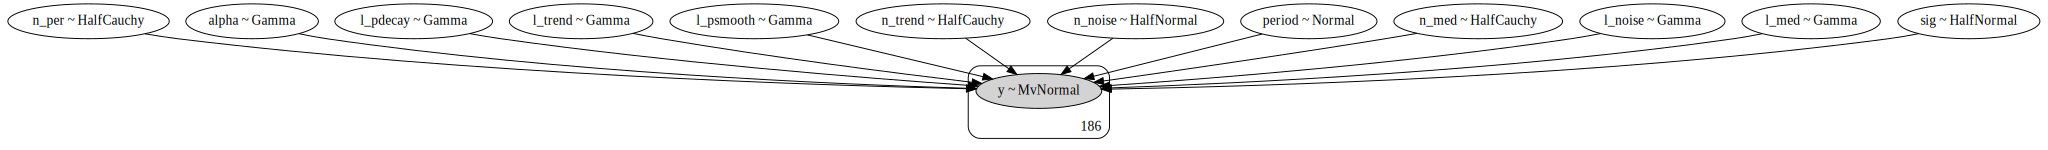

In [44]:
pm.model_to_graphviz(model=model)

In [46]:
priors = pm.sample_prior_predictive(model=model)

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [48]:
with model:
    mp = pm.find_MAP(include_transformed=True)

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is

In [ ]:
# display the results, dont show transformed parameter values
sorted([name+":"+str(mp[name]) for name in mp.keys() if not name.endswith("_")])